# Interktivna vizualizacija podatkov AKOS test net

## Vsebina

Ta notebook omogoča vizualizacijo podatkov zbranih s pomočjo __[AKOS test net](http://akostest.net/)__ aplikacije.

## Predpogoji za uporabo

### Dostop do baze

Notebook zahteva, da je računalniku, na katerem se ta notebook nahaja, omogočen dostop do baze AKOS Test Net.

### Python moduli

Notebook zahteva, da so naslednji Python moduli inštalirani:
* matplotlib
* pandas
* numpy
* sqlalchemy
* subprocess 

## Tok analize
Celice tega notebooka lahko zaženete eno za drugo po vrsti.

## Pre-inicializacija


In [13]:
# Set to database IP. This must be reachable from the machine where this script is ran. 
DB_IP='194.249.4.173'

# Set the database username and password
DB_USER= "akos_js"
DB_PASS= "JaymNod3"

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sqlalchemy import create_engine

engine = create_engine('postgresql://'+DB_USER+':'+DB_PASS+'@'+DB_IP+'/rmbt')

def query( what, params=None ):
    return pd.read_sql(sa.text(what), engine, params=params)


tests = """SELECT DISTINCT name,qos_test_uid, SUM( success_count ) as success_count, SUM( failure_count ) as failure_count, count(qos_test_uid) as provider_test_count
    FROM test, qos_test_result, provider
    WHERE test.uid=qos_test_result.test_uid and provider.uid=test.{provider}provider_id
    GROUP BY name,qos_test_uid
    ORDER BY name,qos_test_uid
"""

rows=""" fetch first :rows rows only"""

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Roboto']
import matplotlib.pyplot as plt
from subprocess import call
%matplotlib inline


## Iskanje v bazi

In [24]:
# Spremenljivka mobile_test vsebuje mobilne teste, oz. teste, kjer je mobile_provider_id definiran
# Spremenljivka fixed_test vsebuje teste, kjer je provider_id definiran

# POZOR: Izvedba spodnjih ukazov traja nekaj časa. 

#fixed_test=query(tests.format(provider=''),params={'rows':1000})
#mobile_test=query(tests.format(provider='mobile_')+rows.{'rows':1000})

mobile_test=query(tests.format(provider='mobile_'))#,params={'rows':30000})

In [22]:
mobile_test

,name,qos_test_uid,success_count,failure_count,provider_test_count
0,"A1 Slovenija, d.d.",75,17741,351,18092
1,"A1 Slovenija, d.d.",76,51118,27370,18064
2,"A1 Slovenija, d.d.",82,18092,126,18092
3,"A1 Slovenija, d.d.",83,17960,248,18092
4,"A1 Slovenija, d.d.",84,17581,456,18037
5,"A1 Slovenija, d.d.",85,17909,128,18037
6,"A1 Slovenija, d.d.",86,18092,123,18092
7,"A1 Slovenija, d.d.",87,17966,242,18092
8,"A1 Slovenija, d.d.",88,146,38,167
9,"A1 Slovenija, d.d.",89,17955,255,18092


## Shranjevanje podatkov
Za hitrejo analizo podatke lahko shranimo na HDD z  ```%store``` ukazom. V naslednjem izvajanju spodnje celice ni treba izvajati.

In [4]:
%store fixed_test
%store mobile_test

Stored 'fixed_test' (DataFrame)
Stored 'mobile_test' (DataFrame)


Ko so podatki enkrat shranjeni, jih lahko preberemo z diska z ukazom ```%store -r```.

In [22]:
# POZOR: poženemo, le ko so podatki shranjeni
%store -r fixed_test
%store -r mobile_test

## Priprava podatkov za analizo

In [18]:
fixed_name = fixed_test.name.unique().tolist() #fixed providers
mobile_name = mobile_test.name.unique().tolist() #mobile providers
#colormap = dict(zip(sorted(list(set(fixed_name+mobile_name))) ,['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf'] ))
colormap = dict(zip(sorted(list(set(fixed_name+mobile_name))) ,['#17becf','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22'] ))

#color mapping
fixed_color=[colormap[provider]   for provider in fixed_name]
mobile_color=[colormap[provider]   for provider in mobile_name]

fixed_test_missing = list((set(mobile_test.qos_test_uid.unique())|set(fixed_test.qos_test_uid.unique()))-set(fixed_test.qos_test_uid.unique()))
mobile_test_missing = list((set(mobile_test.qos_test_uid.unique())|set(fixed_test.qos_test_uid.unique()))-set(mobile_test.qos_test_uid.unique()))

#qos_test_objective = query("SELECT * FROM qos_test_objective")

# Splošna opisna analiza podatkov

## Porazdelitev izvedenih testov po operaterjih

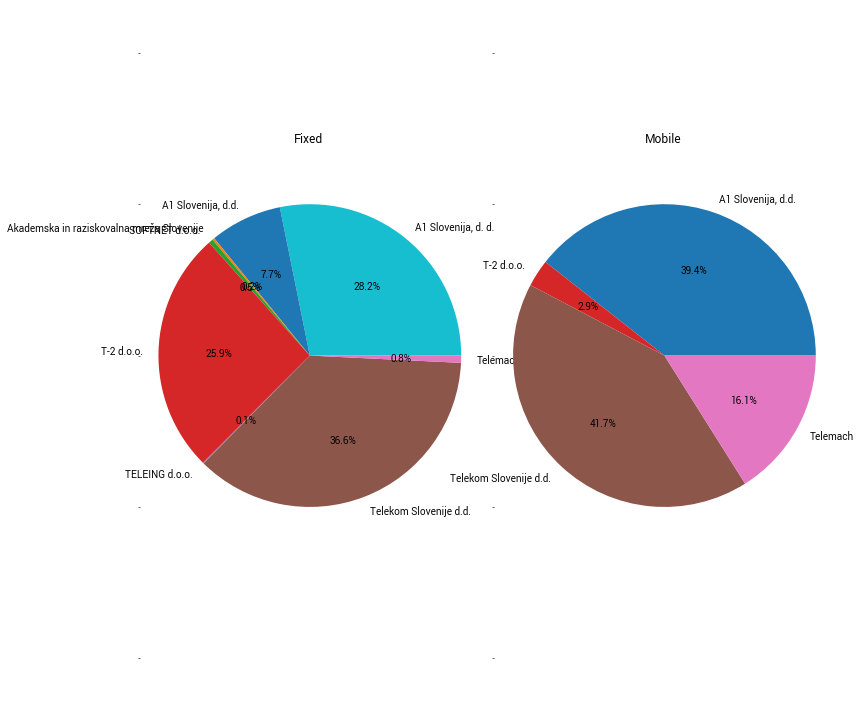

In [19]:
fig, (ax1, ax2, ) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

fixed_test.groupby(['name']).provider_test_count.sum().plot(kind='pie',autopct='%1.1f%%', title='Fixed', ax=ax1, colors=fixed_color ,figsize=(10,10)  )
ax1.set_ylabel('')
ax1.axis('equal')
ax1.set(ylabel='')
ttl = ax1.title
ttl.set_position([0.5, 0.8])

mobile_test.groupby(['name']).provider_test_count.sum().plot(kind='pie', autopct='%1.1f%%', title='Mobile', ax=ax2,colors=mobile_color  )
ax2.set_ylabel('')
ax2.axis('equal')
ax2.set_ylabel('')
ttl = ax2.title
ttl.set_position([0.5, 0.8])

plt.tight_layout()
plt.show()

# Analiza QoS testov

## Odstotek neuspešnih testov in število vseh QoS testov
Prikazani so testi izvršeni na mobilni aplikaciji razvrščeni po tipu testa (test ID).

In [20]:
def append_empty_test (mobile=True):
    if mobile:
        providers = ['qos_test_uid']+mobile_name
        missing_test = mobile_test_missing
    else:
        providers = ['qos_test_uid']+fixed_name  
        missing_test = fixed_test_missing    
    return pd.DataFrame([[missing if i==0 else 0 for i in range(0,len(providers)) ] for missing in missing_test], columns=providers)


def get_test_fail (mobile=True, append_missing=True):
    if mobile:
        table=mobile_test
    else:
        table=fixed_test
    
    #per test failure
    temp = table.groupby(['qos_test_uid'])[['success_count','failure_count']].sum().reset_index()
    temp['test_fail'] = temp['success_count']+temp['failure_count']
    temp['test_fail'] = (temp['failure_count']/temp['test_fail'])*100
    temp = pd.merge(table, temp[['qos_test_uid','test_fail']], on=['qos_test_uid'])

    #calculate test fail per provider and test_id
    temp['provider_test_fail'] = temp['failure_count']/(temp['success_count']+temp['failure_count'])
    #sum provider_test_fail
    temp = pd.merge(temp, temp.groupby(['qos_test_uid'])[['provider_test_fail']].sum().reset_index().rename(columns={'provider_test_fail': 'provider_test_fail_sum'}), on=['qos_test_uid'])
    #calculate fraction of failed per provider and test
    temp['provider_test_fail'] = temp['provider_test_fail']/temp['provider_test_fail_sum']
    #provider_test_fail sums to test_fail
    temp['provider_test_fail'] = temp['provider_test_fail']*temp['test_fail']
    
    temp = temp.pivot('qos_test_uid','name',  'provider_test_fail').reset_index().rename_axis('').rename_axis('', axis=1)
    
    if append_missing:
        temp = append_empty_test(mobile).append(temp, ignore_index=True).sort_values(by='qos_test_uid')
    
    return temp
        
        

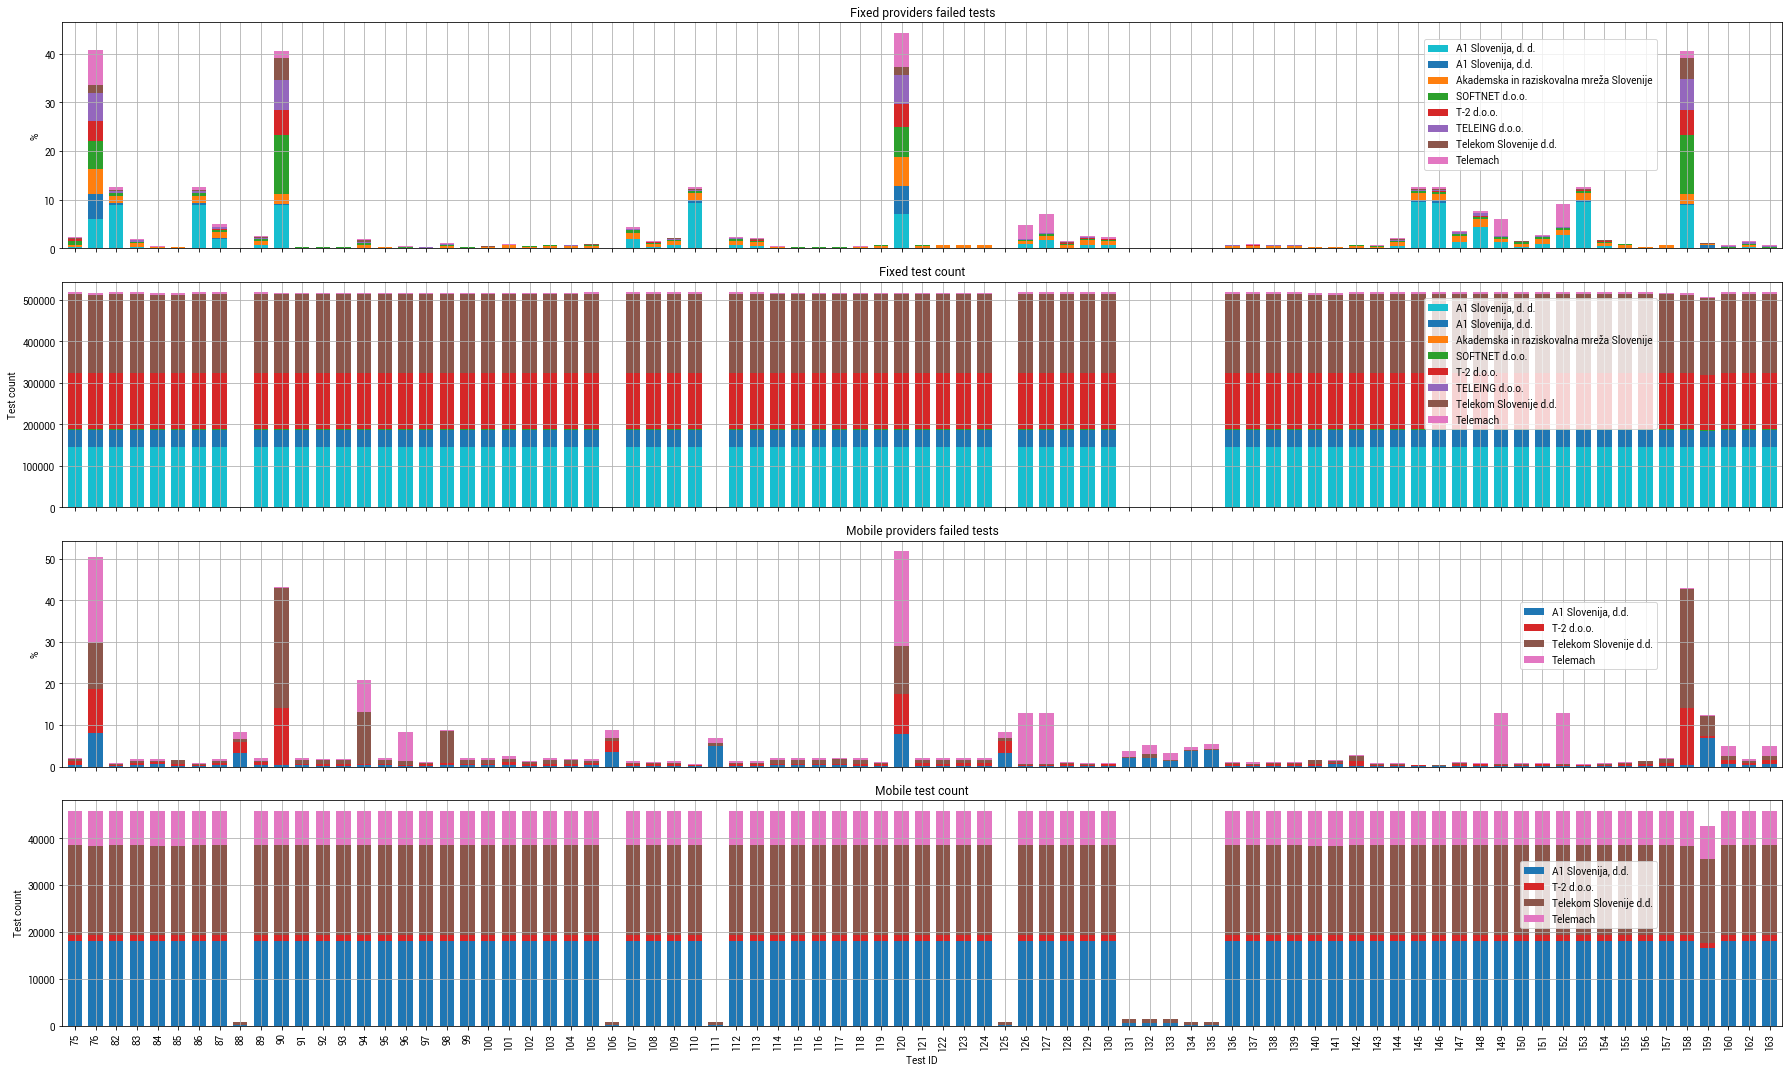

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)

get_test_fail (mobile=False, append_missing=True).plot(ax=ax1, kind='bar', x=['qos_test_uid'], stacked=True,width=0.7,grid=True, figsize=(25,15), title='Fixed providers failed tests', color=fixed_color)
ax1.set_ylabel('%')
ax1.set_xlabel('Test ID')
ax1.legend(bbox_to_anchor=(0.93,0.95), loc='upper right')

fixed_test.pivot('qos_test_uid','name',  'provider_test_count').reset_index().rename_axis('').rename_axis('', axis=1).append(append_empty_test (mobile=False)).sort_values(by='qos_test_uid').plot(
    ax=ax2,kind='bar', x=['qos_test_uid'], stacked=True,width=0.7,grid=True, title='Fixed test count', color=fixed_color)
ax2.set_ylabel('Test count')
ax2.set_xlabel('Test ID')
ax2.legend(bbox_to_anchor=(0.93,0.95), loc='upper right')


get_test_fail (mobile=True, append_missing=True).plot(ax=ax3, kind='bar', x=['qos_test_uid'], stacked=True,width=0.7,grid=True, title='Mobile providers failed tests', color=mobile_color)
ax3.set_ylabel('%')
ax3.set_xlabel('Test ID')
ax3.legend(bbox_to_anchor=(0.93,0.75), loc='upper right')

mobile_test.pivot('qos_test_uid','name',  'provider_test_count').reset_index().rename_axis('').rename_axis('', axis=1).append(append_empty_test (mobile=True)).sort_values(by='qos_test_uid').plot(
    ax=ax4,kind='bar', x=['qos_test_uid'], stacked=True,width=0.7,grid=True, title='Mobile test count', color=mobile_color)
ax4.set_ylabel('Test count')
ax4.set_xlabel('Test ID')
ax4.legend(bbox_to_anchor=(0.93,0.75), loc='upper right')

plt.tight_layout()
#plt.savefig('skupaj.svg')

#call(["inkscape", "--file", "skupaj.svg", "--export-emf", "skupaj.emf" ]) 
#inkscape -f=skupaj.svg --export-emf=test.emf

##  Analiza uspešnosti posameznih testov

In [28]:
def query_tests (mobile=True, test='tcp', dns_unknown=False, record='A' ):
    if mobile:
        table=mobile_test.copy()
        provider=mobile_name
    else:
        table=fixed_test.copy()
        provider=fixed_name
        
    table['percent'] = (table['failure_count']/(table['failure_count']+table['success_count']))*100
    
    ylabel='Test ID'
    
    table = table.pivot('qos_test_uid','name',  'percent').reset_index().rename_axis('').rename_axis('', axis=1)
    table = pd.merge(table, qos_test_objective,  left_on=['qos_test_uid'], right_on=['uid'])
    table = table[table['test']==test]
    if test in ['tcp','udp','voip']: #za voip se dodatne teste
        table['x'] = table.param.apply(lambda x: x.get('out_port'))
        ylabel+= ', port'
    elif test=='traceroute':
        table['x'] = table.param.apply(lambda x: x.get('host'))
        ylabel+= ', host'
    elif test in ['website','http_proxy']:
        table['x'] = table.param.apply(lambda x: x.get('url'))
        ylabel+= ', url'
    elif test=='non_transparent_proxy':
        table['x'] = table.param.apply(lambda x: 'Port: '+x.get('port')+'\n'+'Request: '+x.get('request'))
        ylabel+= ', port, request'
    elif test=='dns':
        table = table[table.param.apply(lambda x: x.get('record')==record)]
        if not dns_unknown:
            table = table[table.test_desc=='dns.testinfo']
        else:
            table = table[table.test_desc=='dns.unknowndomain.info']
        table['x'] = table.param.apply(lambda x: ''+x.get('host')+'\nRecord: '+x.get('record')+ ('\n' if x.get('resolver')==None else '\n'+x.get('resolver')))
        ylabel+= ', host, record, resolver'
    
    
    table['x'] = table.apply(lambda x:'T_ID:'+str(x.qos_test_uid)+'\n'+x.x, axis=1) 
    table.drop(set(table.columns.tolist())-set(provider+['x']), axis=1, inplace=True)
    table.set_index('x',inplace=True)
    table.index.rename(ylabel, inplace=True)   
    return table

def plot_mob_fix_test (test='tcp', dns_unknown=False, record='A'):
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False)
    query_tests(mobile=True, dns_unknown=dns_unknown, test=test, record=record).plot(kind='bar', stacked=False,width=0.7,grid=True, color=mobile_color,figsize=(30,8), rot=0, ax=ax1)
    query_tests(mobile=False, dns_unknown=dns_unknown, test=test, record=record).plot(kind='bar', stacked=False,width=0.7,grid=True, color=fixed_color,figsize=(30,8), rot=0, ax=ax2)
    
    ax1.set_ylabel('Failed percentage'); ax2.set_ylabel('Failed percentage')
    ax1.set_title('Mobile provider', loc='left'); ax2.set_title('Fixed provider', loc='left')
    fig.suptitle(test.upper() if test!='dns' else ('Unknown domain '+test.upper()+', Record='+record if dns_unknown else test.upper()+', Record='+record) , fontsize=16, horizontalalignment='center')
    plt.tight_layout()

### TCP QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja TCP testov pri mobilnih in fiksnih operaterjev.

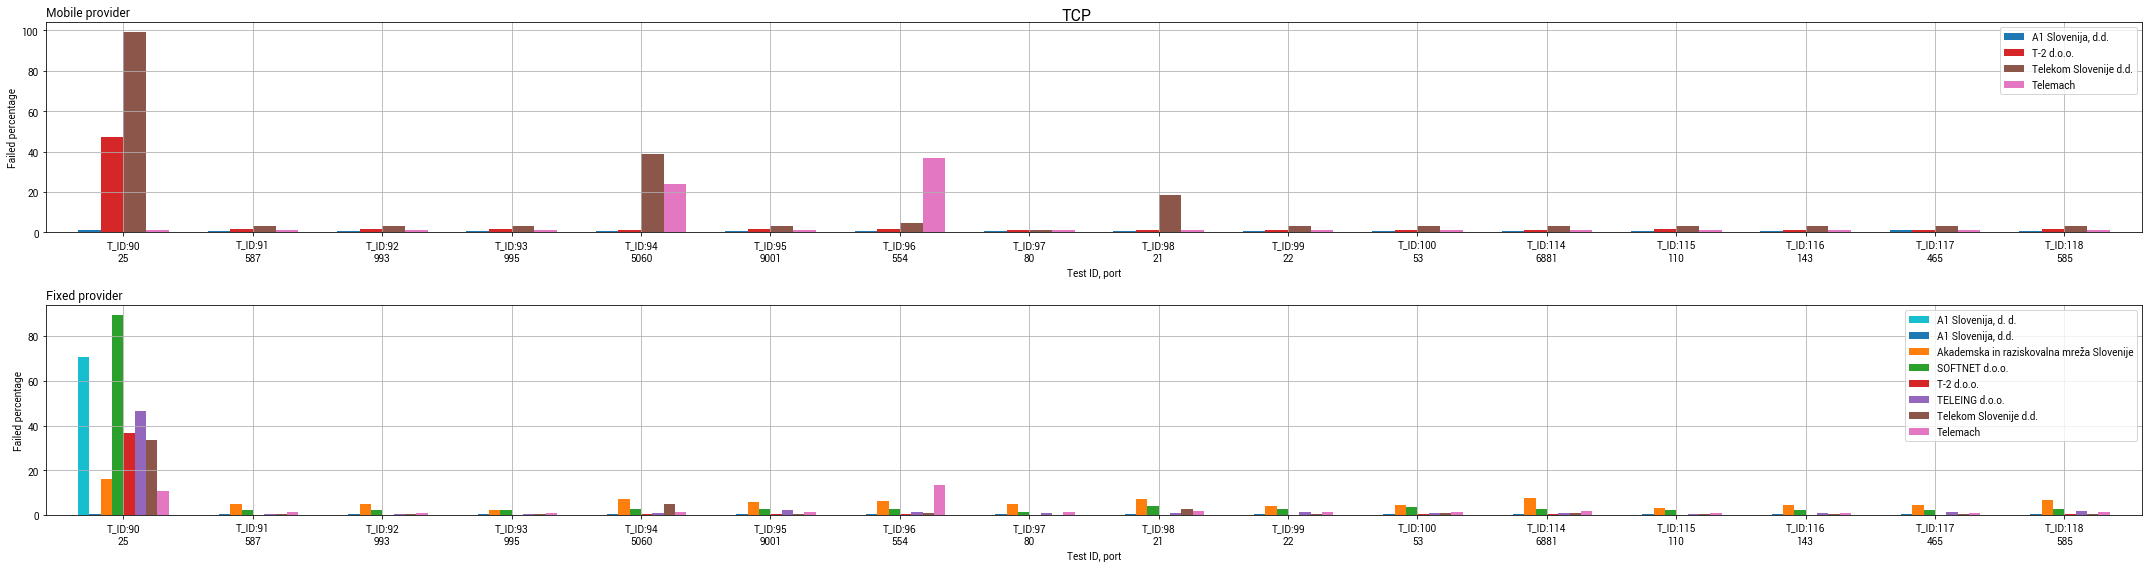

In [29]:
plot_mob_fix_test(test='tcp')

### UDP QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja UDP testov pri mobilnih in fiksnih operaterjev.

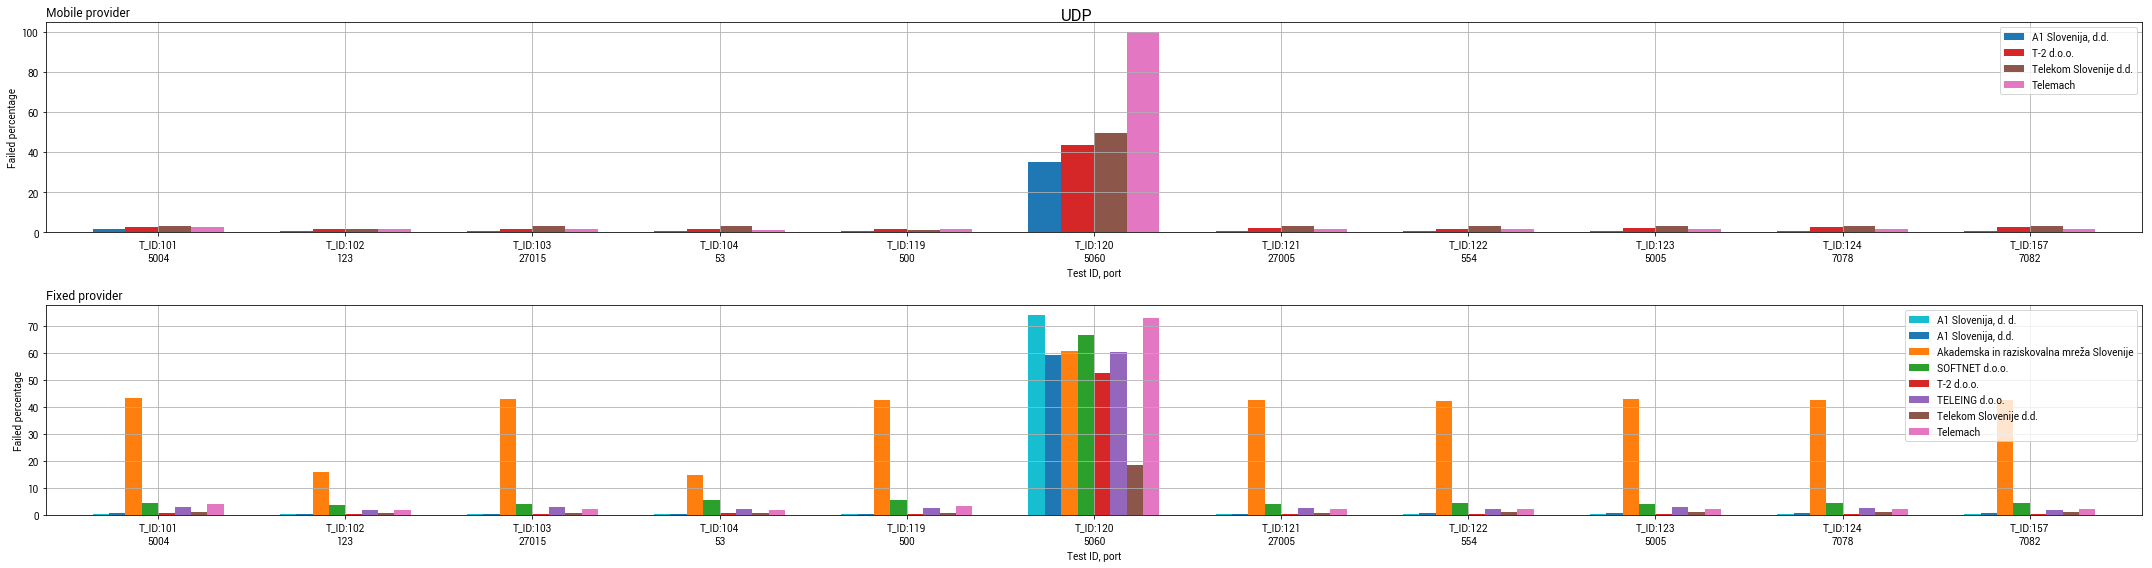

In [30]:
plot_mob_fix_test(test='udp')

### VoIP QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja VoIP testov pri mobilnih in fiksnih operaterjev.

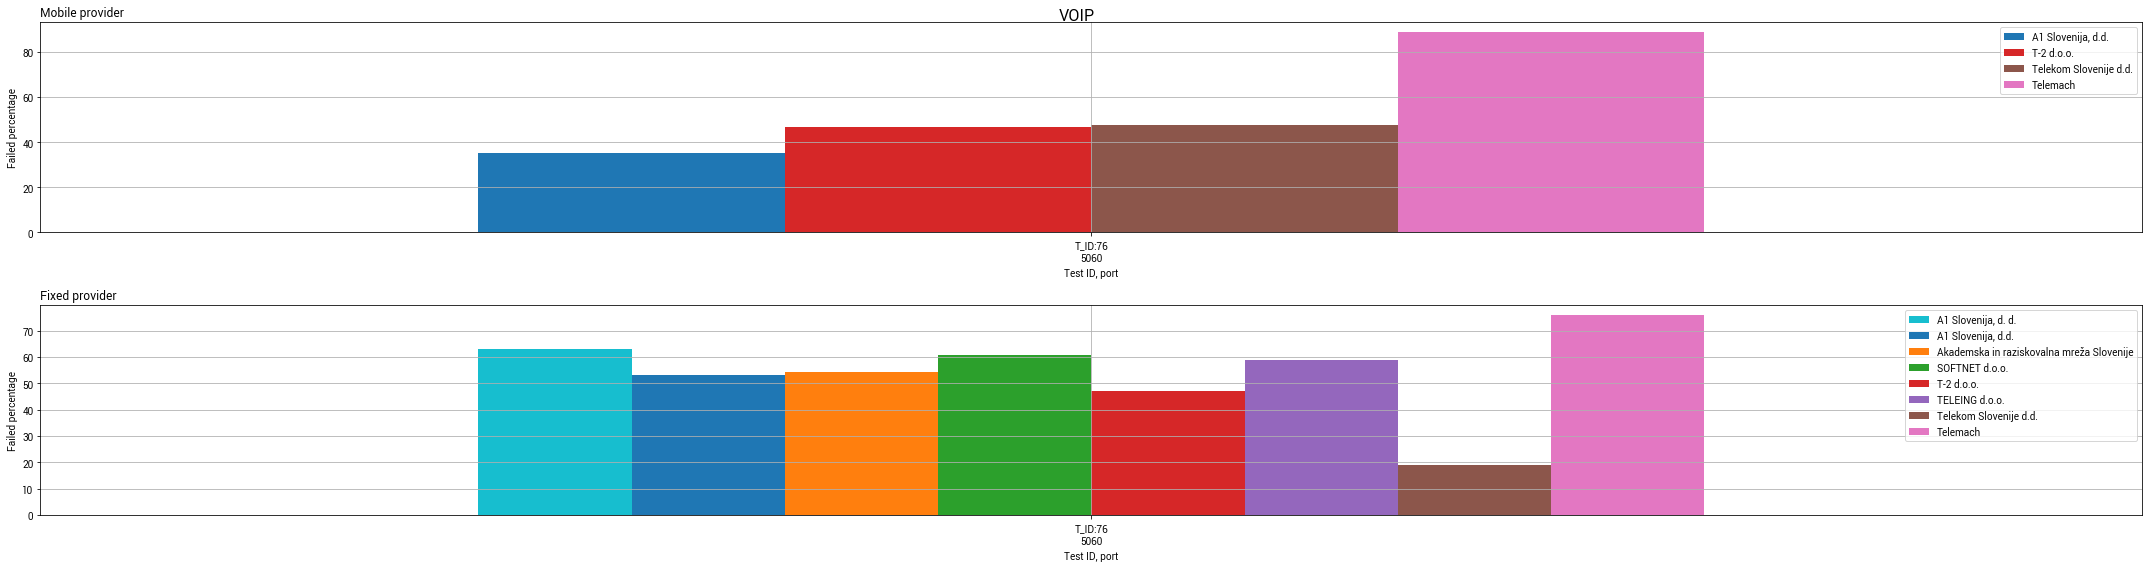

In [31]:
plot_mob_fix_test(test='voip')

### Traceroute QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja traceroute testov pri mobilnih in fiksnih operaterjev.

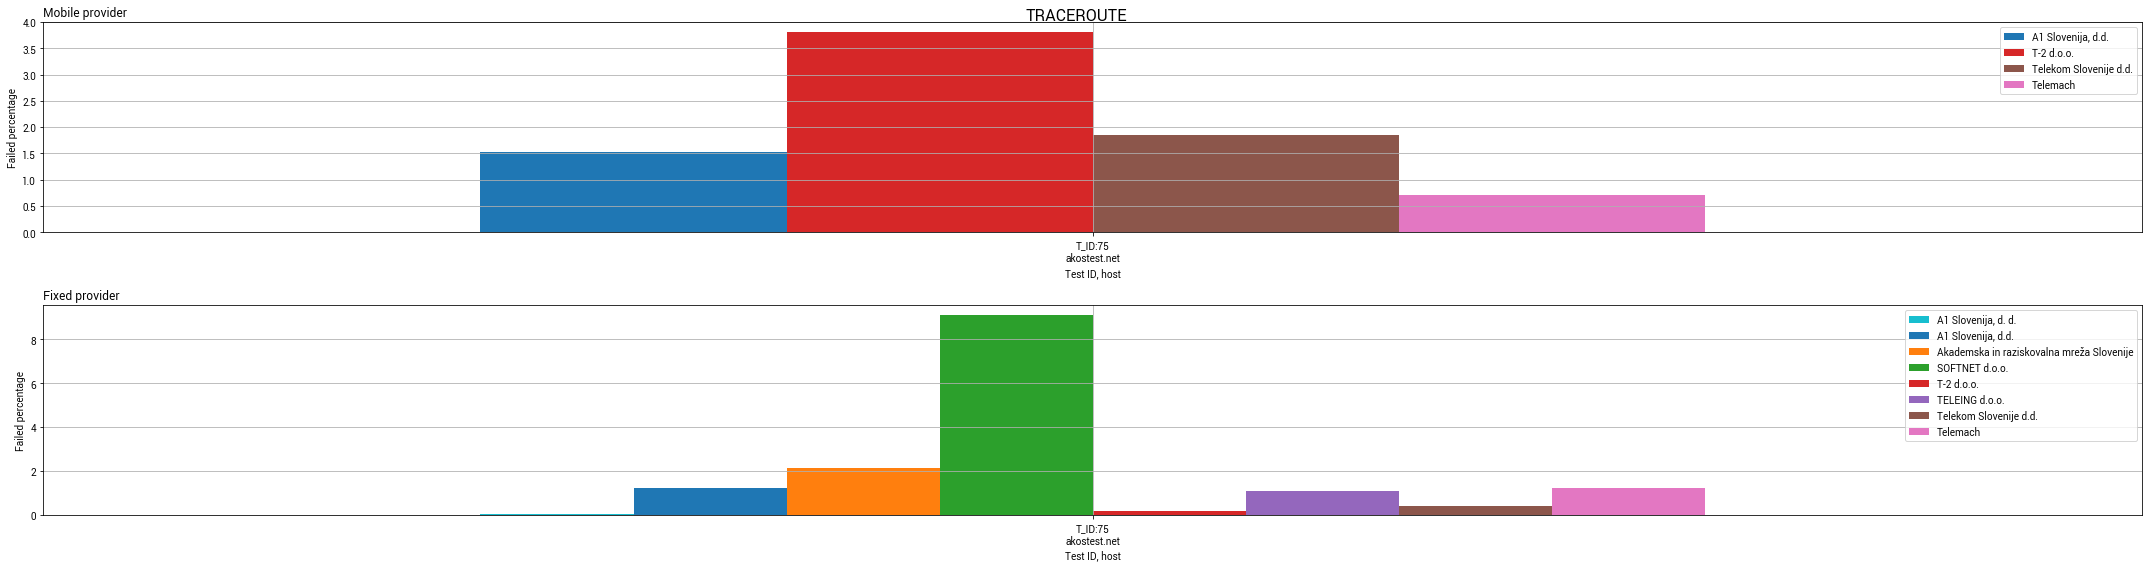

In [32]:
plot_mob_fix_test(test='traceroute')

### Website QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja website testov pri mobilnih in fiksnih operaterjev.

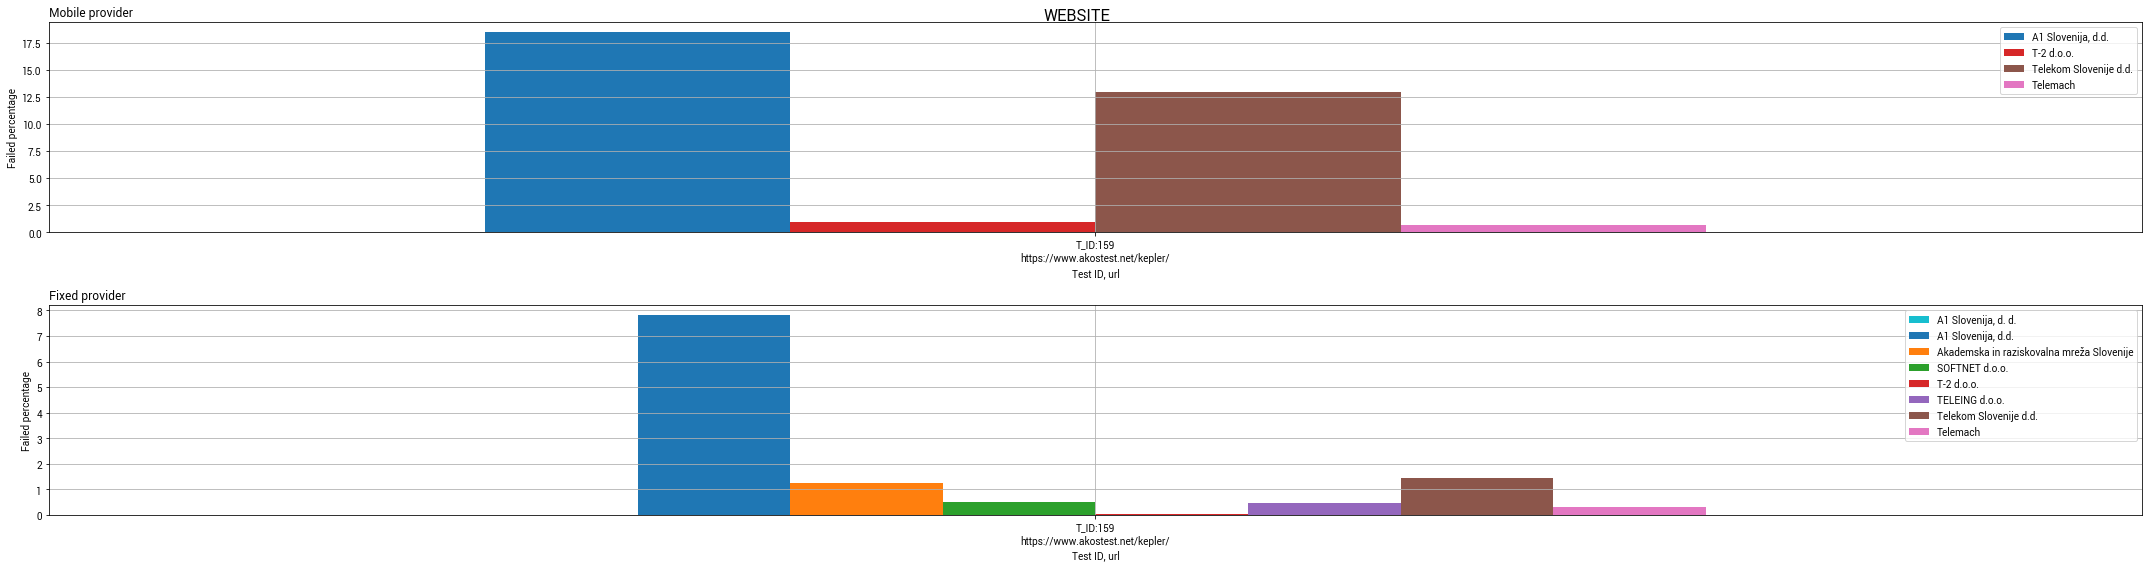

In [33]:
plot_mob_fix_test(test='website')

### HTTP Proxy QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja HTTP proxy testov pri mobilnih in fiksnih operaterjev.

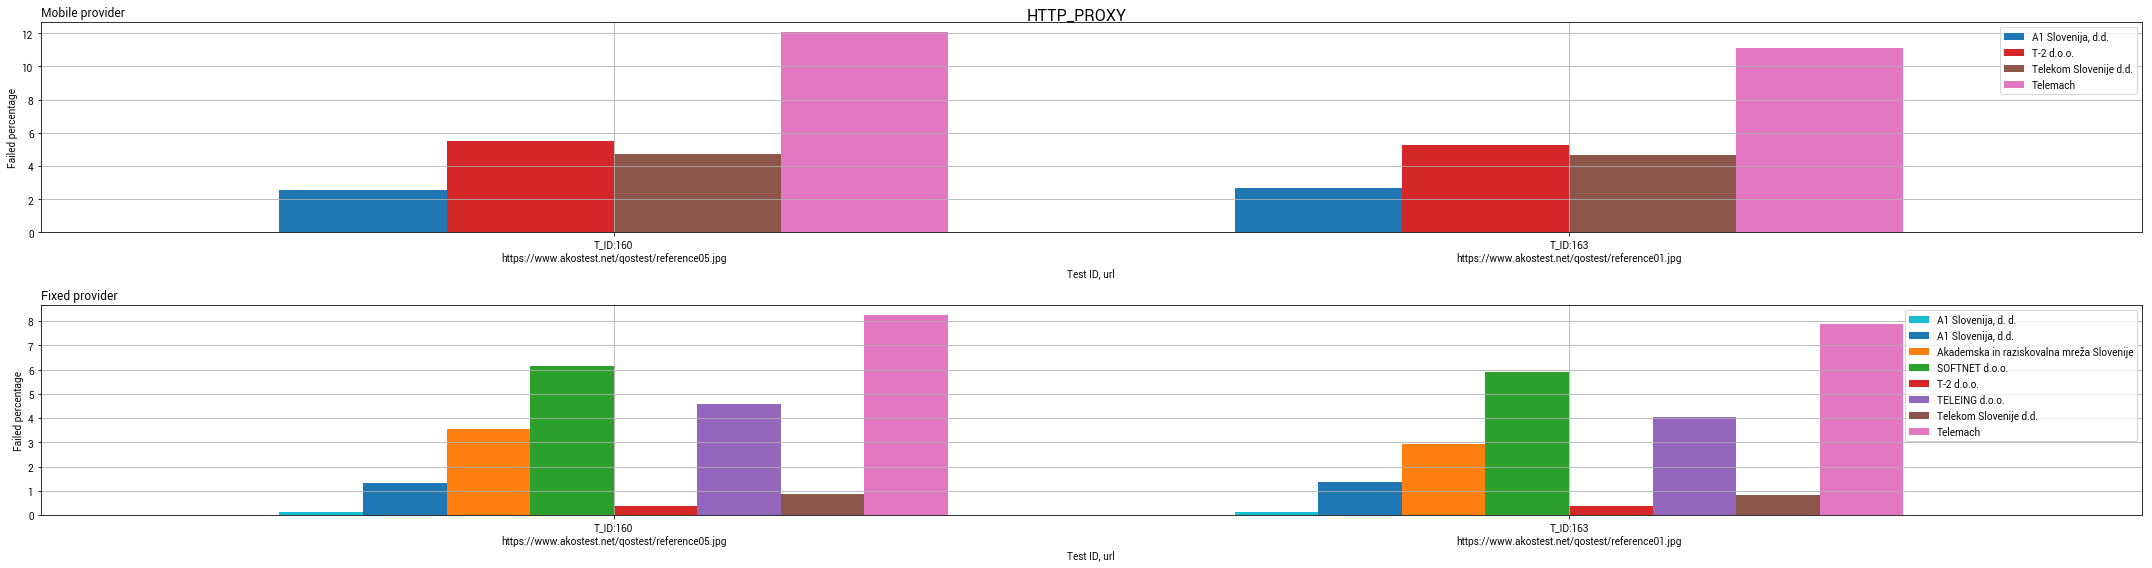

In [13]:
plot_mob_fix_test(test='http_proxy')

### Non-transparent Proxy QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja non-transparent proxy testov pri mobilnih in fiksnih operaterjev.

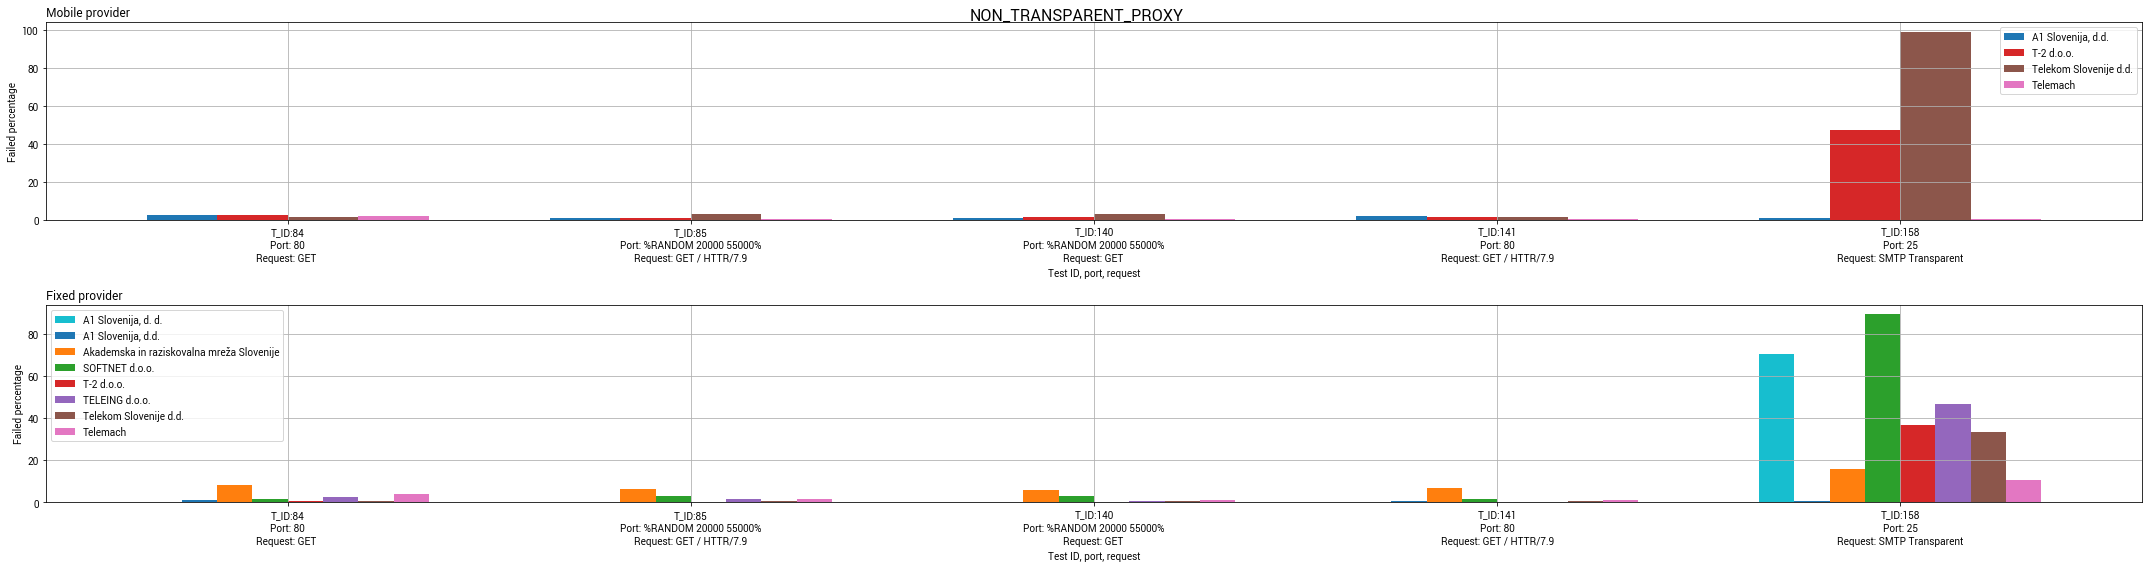

In [14]:
plot_mob_fix_test(test='non_transparent_proxy')

### DNS record=A QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja DNS record=A testov pri mobilnih in fiksnih operaterjev.

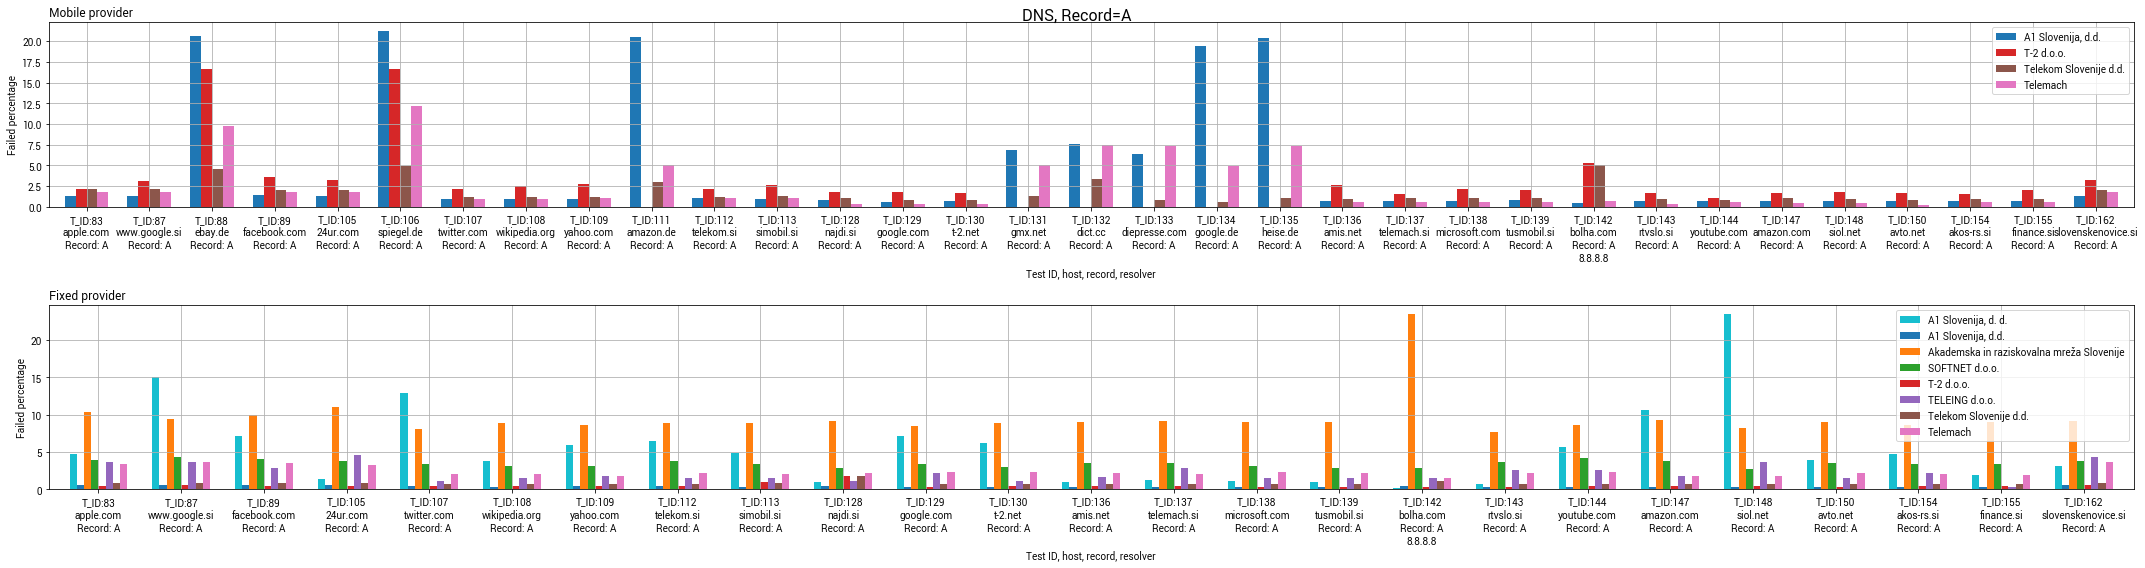

In [15]:
plot_mob_fix_test(test='dns', dns_unknown=False, record='A')

### DNS record=AAAA QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja DNS record=AAAA testov pri mobilnih in fiksnih operaterjev.

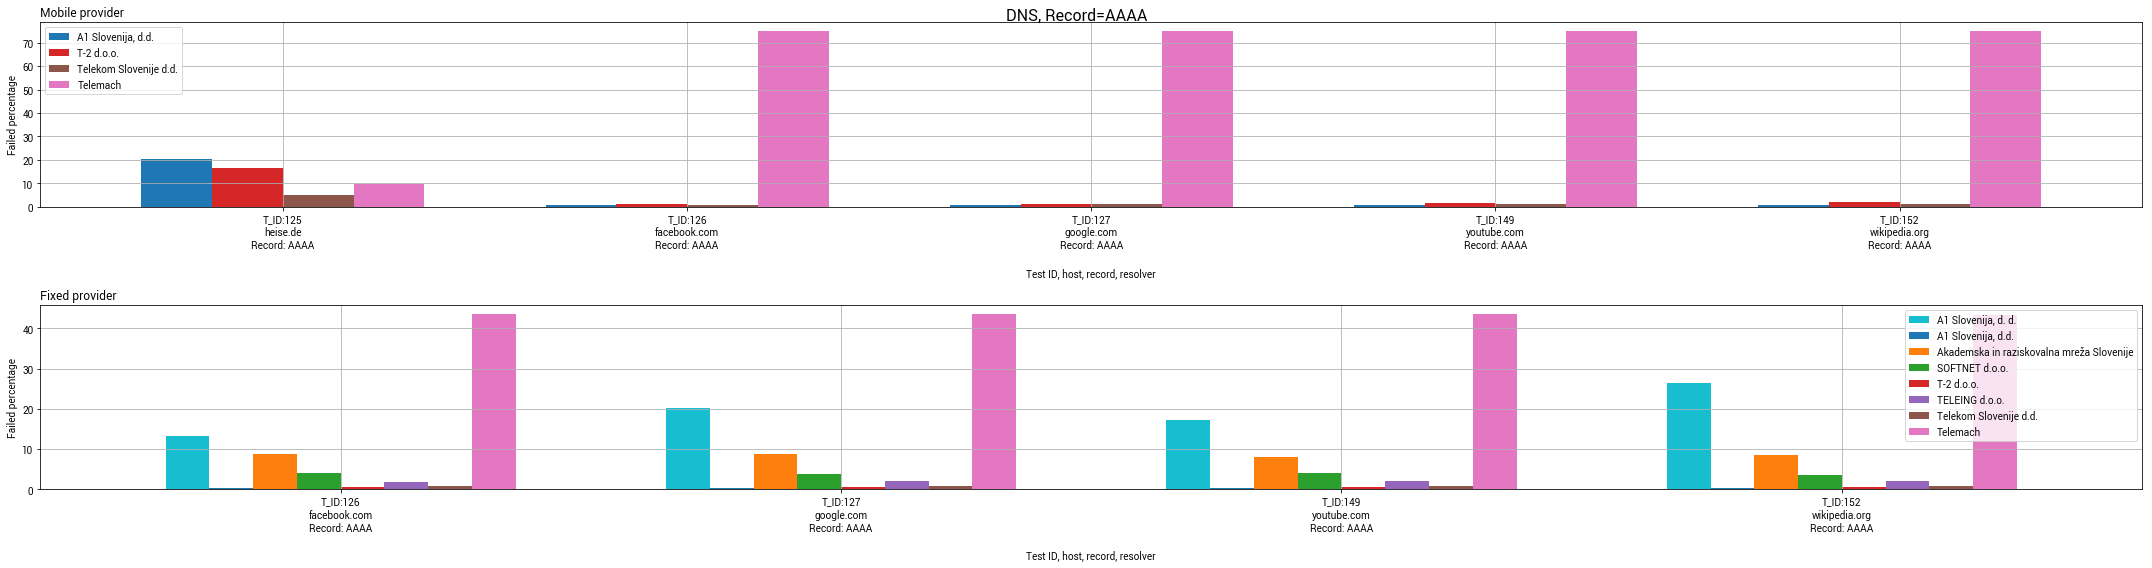

In [16]:
plot_mob_fix_test(test='dns', dns_unknown=False, record='AAAA')

### DNS record=MX QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja DNS record=MX testov pri mobilnih in fiksnih operaterjev.

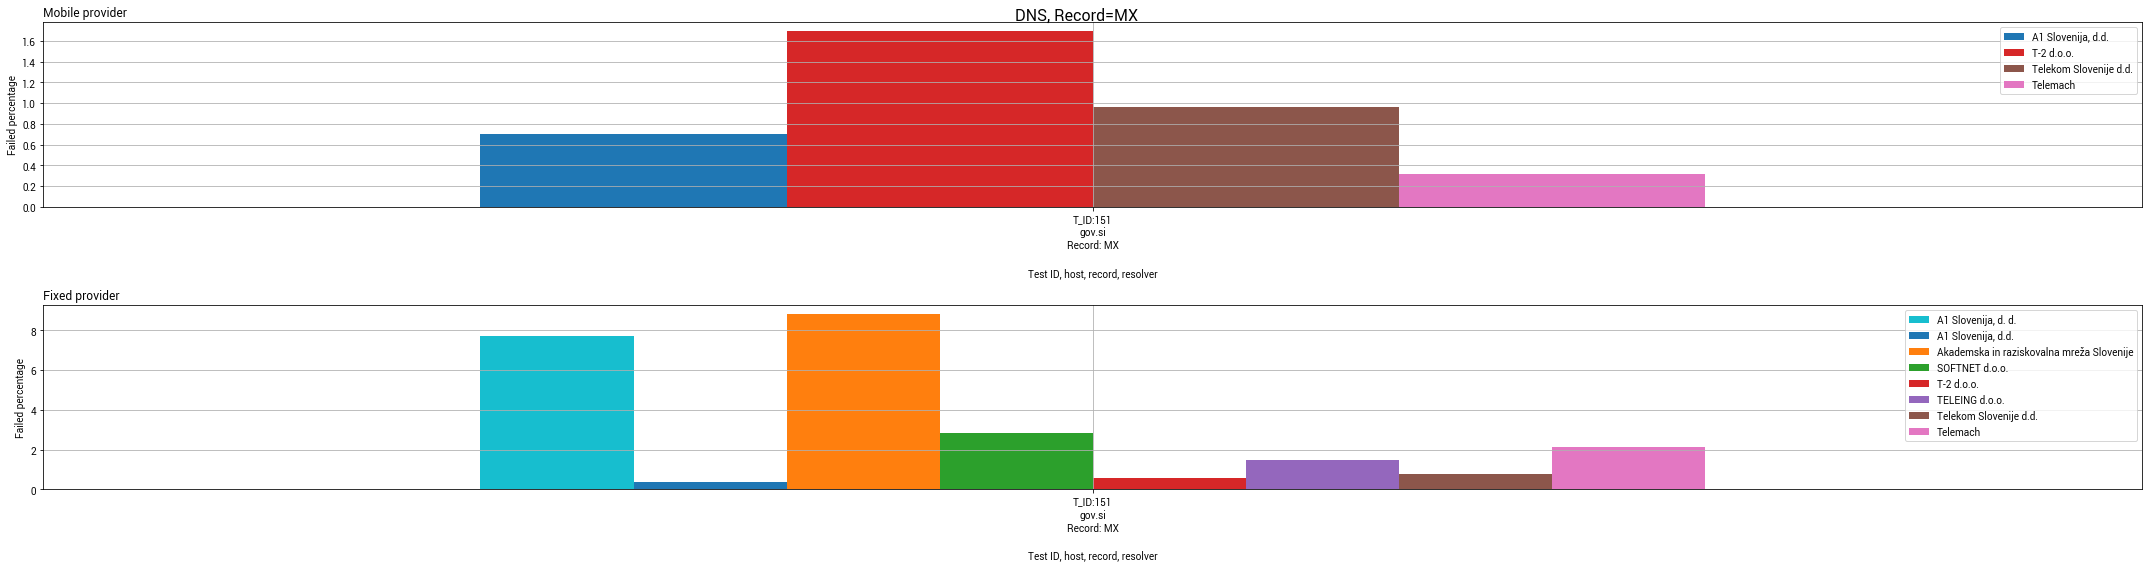

In [17]:
plot_mob_fix_test(test='dns', dns_unknown=False, record='MX')

### DNS unknown domain QoS testi
Na spodnjih slikah so prikazane neuspešnosti izvajanja DNS record=A unknown domain testov pri mobilnih in fiksnih operaterjev.

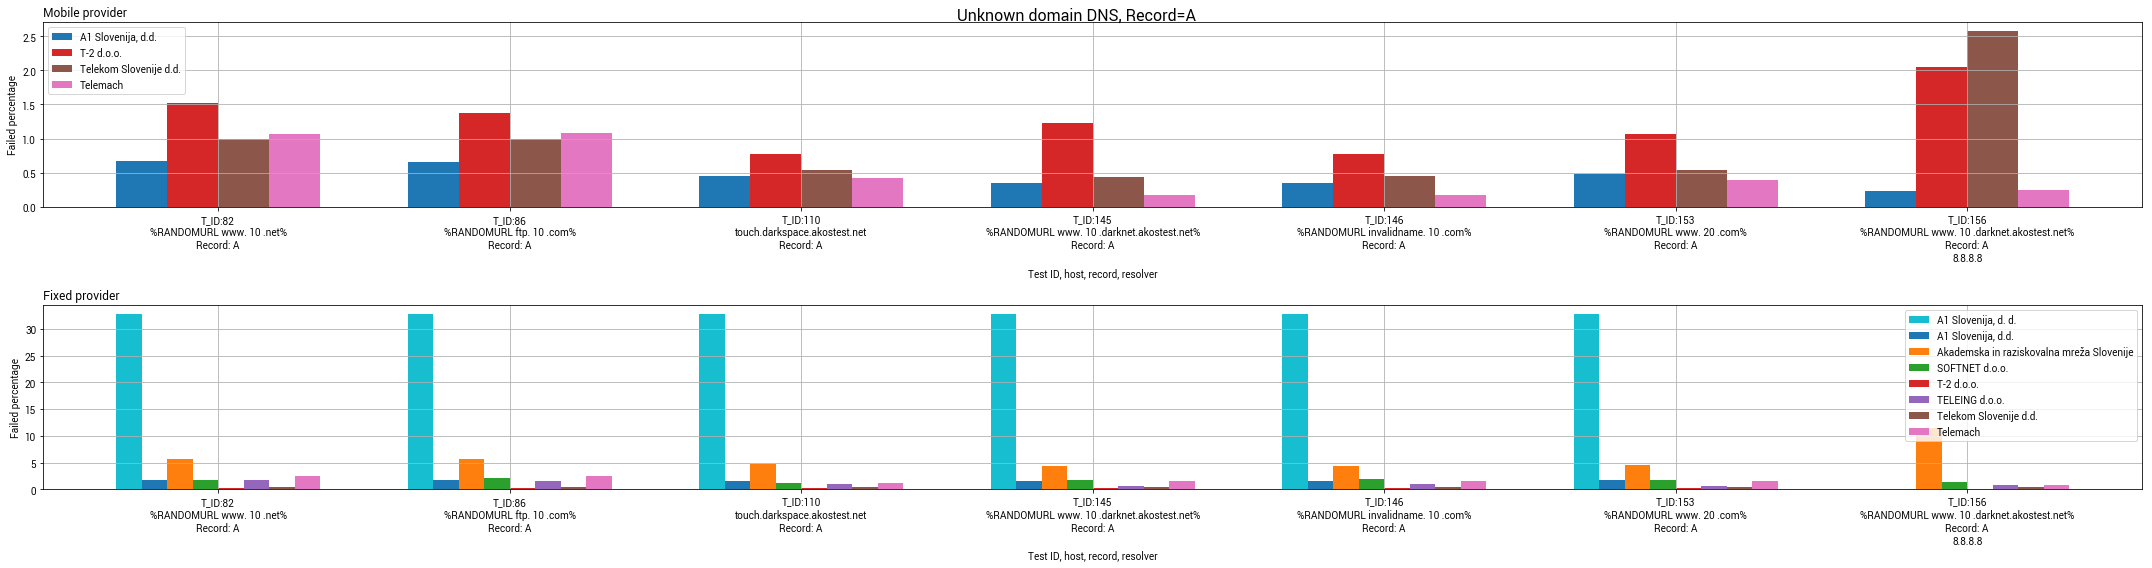

In [18]:
plot_mob_fix_test(test='dns', dns_unknown=True, record='A')

## Analiza VoIP testov

POZOR: VoIP testi narobe štejejo ```success_count``` in ```failure_count``` vrednosti. Včasih je ```jitter=0```, kar se šteje kot uspešen test, čeprav ostali testi niso bili uspešni. Posledično, teste, ki imajo jitter in št. paketov  manj kot 10 obravnavamo kot neuspešne. Dodatno, če so vsi testi uspešni je ```max success_count=4```, če niso pa je ```max failure_count=5```. Zakaj se ```voip_result_status=='TIMEOUT'``` šteje kot neuspešen test, če se ```voip_result_status=='OK'``` pa se ne šteje kot uspešen?

In [20]:
voip_query = "SELECT name,success_count,failure_count,result,lte_rsrp,lte_rsrq,signal_strength  FROM qos_test_result,test,provider  WHERE qos_test_uid=76 and test_uid=test.uid and test.{provider}provider_id=provider.uid"
#qos_test_objective
voip_mobile = query(voip_query.format(provider='mobile_'))
#Evalvacija testa
#{'on_failure': 'voip.jitter.outgoing.failure', 'evaluate': '%EVAL if (nn.coalesce(voip_result_out_mean_jitter, 50000000) < 50000000) result=true; else result=false;%', 'on_success': 'voip.jitter.outgoing.success'}, 
#{'on_failure': 'voip.jitter.incoming.failure', 'evaluate': '%EVAL if (nn.coalesce(voip_result_in_mean_jitter, 50000000) < 50000000) result=true; else result=false;%', 'on_success': 'voip.jitter.incoming.success'}, 
#{'on_failure': 'voip.outgoing.packet.failure', 'evaluate': '%EVAL if (nn.coalesce(voip_result_out_num_packets, 0) > 0) result=true; else result=false;%', 'on_success': 'voip.outgoing.packet.success'}, 
#{'on_failure': 'voip.incoming.packet.failure', 'evaluate': '%EVAL if (nn.coalesce(voip_result_in_num_packets, 0) > 0) result=true; else result=false;%', 'on_success': 'voip.incoming.packet.success'}, 
#{'evaluate': '%EVAL if(voip_result_status=='TIMEOUT') result={type: 'failure', key: 'voip.timeout'}%'}]

POZOR: Za analizo VoIP testov v Orangeu z AKOS_VoIP_test workflowom je potrebno shraniti rezultate querya v pandas datarame na HDD s spodnjim ukazom

In [21]:
%store voip_mobile

Stored 'voip_mobile' (DataFrame)


### Odvisnost VoIP jitter in packet in/out parametrov od signala (RSRQ, RSRP) 

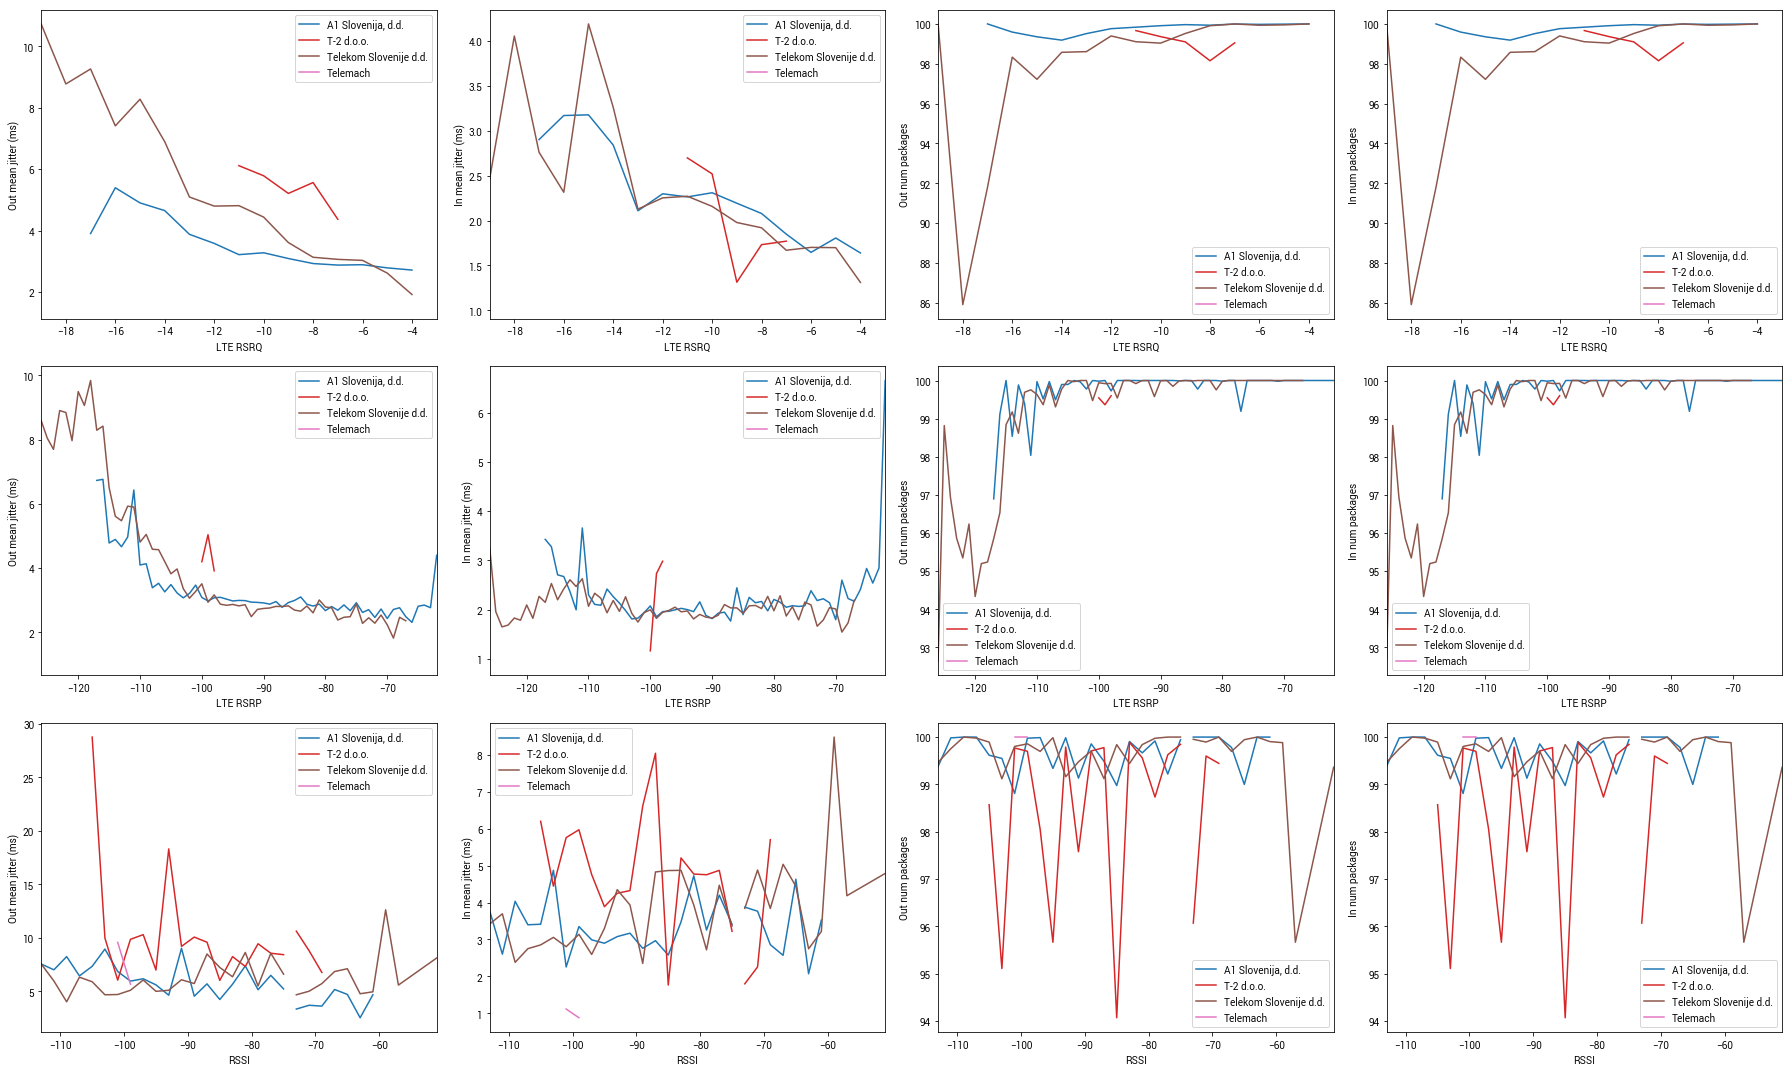

In [50]:
def clean_voip(x, col, val):
    temp = x.get(col)
    if temp is None or temp<=val:
        return None
    else:
        if col.endswith('mean_jitter'):
            return temp/10**6
        else:
            return temp
    
voip_mobile['out_mean_jitter'] = voip_mobile.result.apply(lambda x: clean_voip(x,'voip_result_out_mean_jitter',10))
voip_mobile['in_mean_jitter'] = voip_mobile.result.apply(lambda x: clean_voip(x,'voip_result_in_mean_jitter',10))
voip_mobile['out_num_packets'] = voip_mobile.result.apply(lambda x: clean_voip(x,'voip_result_out_num_packets',10))
voip_mobile['in_num_packets'] = voip_mobile.result.apply(lambda x: clean_voip(x,'voip_result_out_num_packets',10))
voip_mobile['Status'] = voip_mobile.result.apply(lambda x: x.get('voip_result_status'))

voip_mobile['lte_rsrq'] = voip_mobile['lte_rsrq'].apply(lambda x: np.nan if x >-3 and x < 3 else x)
voip_mobile['lte_rsrq'] = voip_mobile['lte_rsrq'].apply(lambda x: np.nan if x <-19.5 else x)
voip_mobile['lte_rsrq'] = voip_mobile['lte_rsrq'].apply(lambda x: -1*x if x >2 else x)

# voip_mobile['failure_count_corrected'] = voip_mobile.apply(lambda x: (1 if pd.isnull(x.out_mean_jitter or not x.out_mean_jitter<50 )  else 0)
#                                                            + (1 if pd.isnull(x.in_mean_jitter)  or not x.in_mean_jitter<50 else 0)
#                                                            + (1 if pd.isnull(x.out_num_packets) or not x.out_num_packets>5 else 0 )
#                                                            + (1 if pd.isnull(x.in_num_packets) or not x.in_num_packets>5 else 0 )
#                                                            + (1 if x.Status!='OK' else 0), axis=1) 


rows = [('lte_rsrq', 'LTE RSRQ'), ('lte_rsrp','LTE RSRP'), ('signal_strength','RSSI')]
cols = [('out_mean_jitter','Out mean jitter (ms)'), ('in_mean_jitter','In mean jitter (ms)'),('out_num_packets','Out num packages'), ('in_num_packets','In num packages')]

fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=False, sharey=False)

for ax,((row,row_label),(col,col_label)) in zip(axes.flat , [(row,col) for row in rows for col in cols]):
    voip_mobile.groupby(['name',row]).filter(lambda x: x[row].count()>=15).groupby(['name',row]).mean().reset_index().pivot(row, 'name', col).reset_index().rename_axis('').rename_axis('', axis=1).plot(ax=ax, x=row, figsize=(25,15), color=mobile_color)
    ax.set(xlabel=row_label, ylabel=col_label)

plt.tight_layout()
plt.show()

## Analiza hitrosti 

### Odvisnost hitrosti pinga od signala (RSRQ, RSRP, RSSI) po operaterjih 

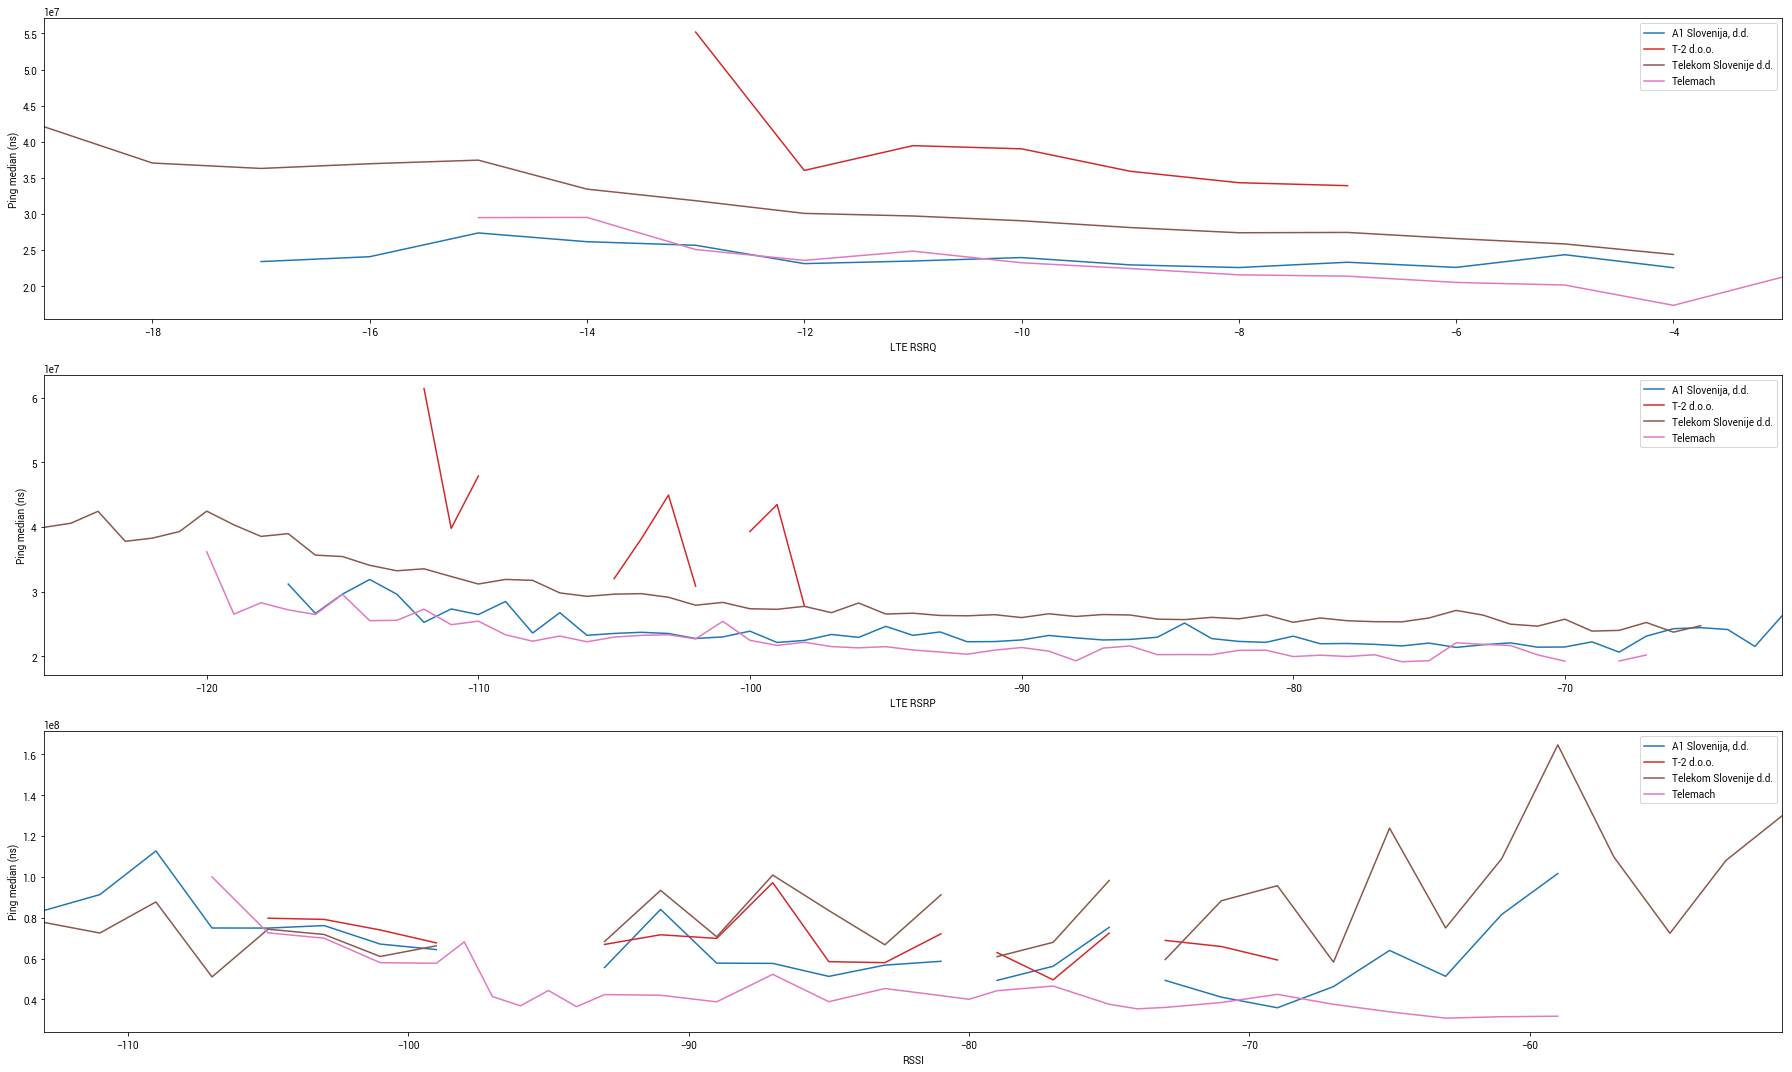

In [51]:
ping_query = "SELECT name,lte_rsrp,lte_rsrq,signal_strength,ping_median,plattform  FROM test,provider  WHERE test.{provider}provider_id=provider.uid"
ping = query(ping_query.format(provider='mobile_'))

ping['lte_rsrq'] = ping['lte_rsrq'].apply(lambda x: np.nan if x >-3 and x < 3 else x)
ping['lte_rsrq'] = ping['lte_rsrq'].apply(lambda x: np.nan if x <-19.5 else x)
ping['lte_rsrq'] = ping['lte_rsrq'].apply(lambda x: -1*x if x >2 else x)

rows = [('lte_rsrq', 'LTE RSRQ'), ('lte_rsrp','LTE RSRP'), ('signal_strength','RSSI')]
cols = [('ping_median','Ping median (ns)')]

fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=False, sharey=False)

for ax,((row,row_label),(col,col_label)) in zip(axes.flat , [(row,col) for row in rows for col in cols]):
    ping.groupby(['name',row]).filter(lambda x: x[row].count()>=15).groupby(['name',row]).mean().reset_index().pivot(row, 'name', col).reset_index().rename_axis('').rename_axis('', axis=1).plot(ax=ax, x=row, figsize=(25,15), color=mobile_color)
    ax.set(xlabel=row_label, ylabel=col_label)

plt.tight_layout()
plt.show()

### Odvisnost hitrosti pinga od platforme

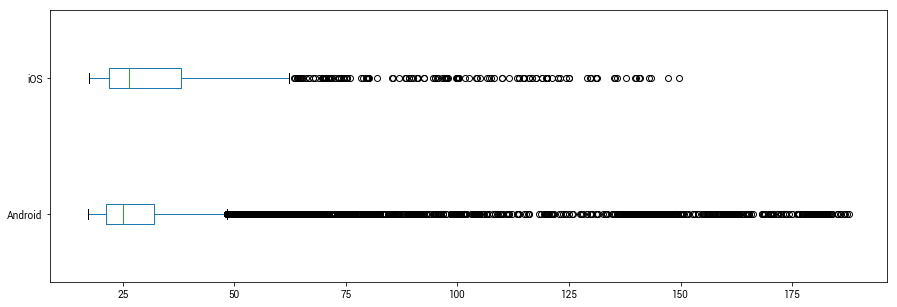

In [52]:
pingAndr = ping[ping.plattform=='Android'].ping_median/10**(6)
pingIOS = ping[ping.plattform=='iOS'].ping_median/10**(6)

pingAndr=pingAndr[pingAndr.between(*pingAndr.quantile((.02, .98)))]
pingIOS=pingIOS[pingIOS.between(*pingIOS.quantile((.02, .98)))]

ax =pd.DataFrame({'Android':pingAndr,'iOS':pingIOS}).plot.box(vert=False, figsize=(15,5))

### Odvisnost hitrosti prenosa od kakovosti signala
Prikazani so rezultati, kjer je vsaj 15 opravljenih meritev (povprečje prenosa po številu meritev kakovosti signala)

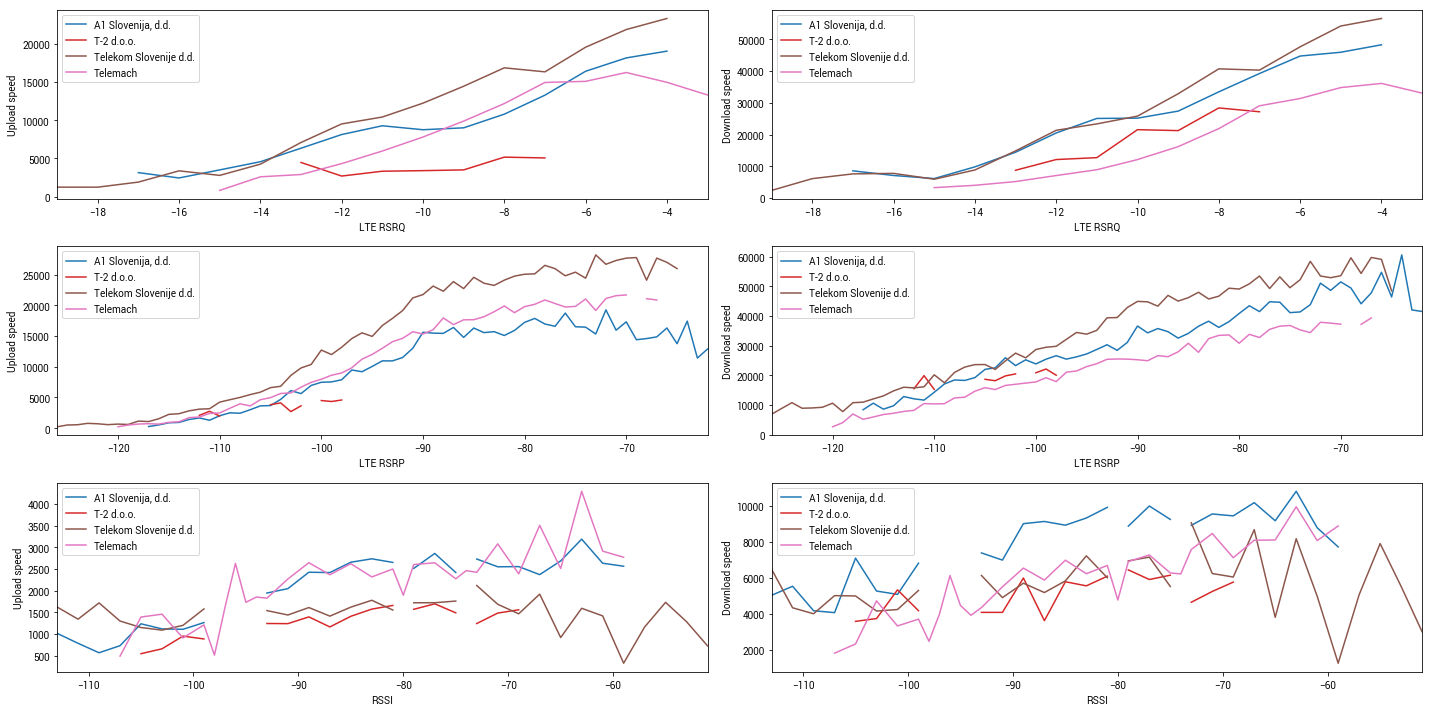

In [53]:
signal = query("SELECT lte_rsrp,lte_rsrq,signal_strength,speed_upload,speed_download,name FROM test,provider WHERE mobile_provider_id=provider.uid and plattform='Android'")
#VTR-L29', 'GT-I9305', 'WAS-LX1', 'MHA-L29', 'HUAWEI VNS-L21','GT-I8730', 'VKY-L29 imajo pozitivne vrednosti
signal['lte_rsrq'] = signal['lte_rsrq'].apply(lambda x: np.nan if x >-3 and x < 3 else x)
signal['lte_rsrq'] = signal['lte_rsrq'].apply(lambda x: np.nan if x <-19.5 else x)
signal['lte_rsrq'] = signal['lte_rsrq'].apply(lambda x: -1*x if x >2 else x)


rows = [('lte_rsrq', 'LTE RSRQ'), ('lte_rsrp','LTE RSRP'), ('signal_strength','RSSI')]
cols = [('speed_upload', 'Upload speed'), ('speed_download', 'Download speed')]

fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=False, sharey=False)

for ax,((row,row_label),(col,col_label)) in zip(axes.flat , [(row,col) for row in rows for col in cols]):
    signal.groupby(['name',row]).filter(lambda x: x[row].count()>=15).groupby(['name',row]).mean().reset_index().pivot(row, 'name', col).reset_index().rename_axis('').rename_axis('', axis=1).plot(
        ax=ax, x=row, figsize=(20,10), color=mobile_color)
    ax.set(xlabel=row_label, ylabel=col_label)

plt.tight_layout()
#plt.savefig('signali.svg')
#call(["inkscape", "--file", "signali.svg", "--export-emf", "signali.emf" ]) 
plt.show()
    

### Spletni testi hitrosti po ponudnikih in brskalnikih - Število testov po brskalnikih

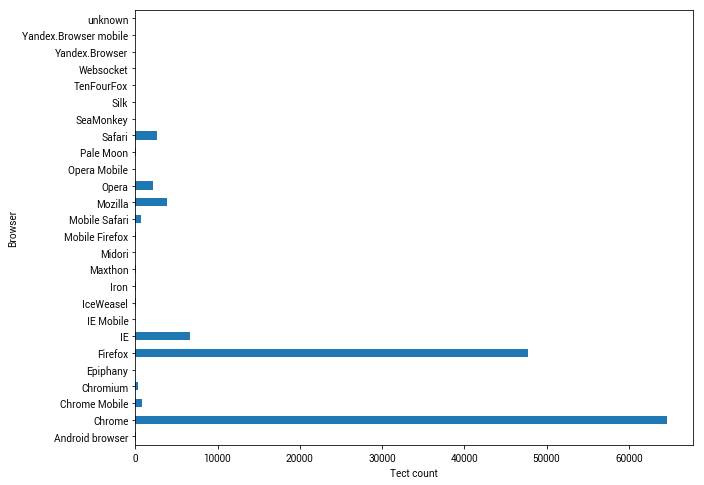

In [19]:
LAN = query("SELECT * FROM test,provider WHERE test.network_type=98 AND provider_id=provider.uid")
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
LAN.groupby('model').count().plot(kind='barh', y='client_id', legend=False, figsize=(10, 8), ax=ax)
ax.set(xlabel='Tect count', ylabel='Browser')
plt.show()

### Spletni testi hitrosti po ponudnikih in brskalnikih - Povprečna hitrost prenosa 
Prikazani so rezultati, kjer je se je test izvedel vsaj 40 krat po ponudniku

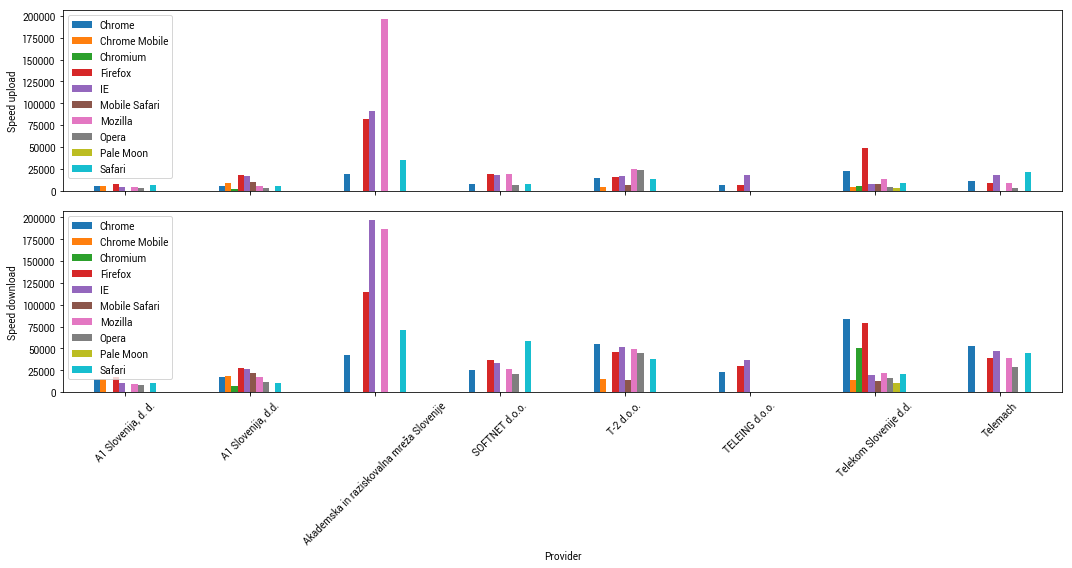

In [42]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
LAN.groupby(['name','model']).filter(lambda x: x['model'].count()>=40).groupby(['name','model']).mean().reset_index().pivot('name', 'model', 'speed_upload').reset_index().rename_axis('').rename_axis('', axis=1).plot(x='name', kind='bar', rot=45, figsize=(15, 8), ax=ax1)
ax1.set(xlabel='Provider', ylabel='Speed upload')
LAN.groupby(['name','model']).filter(lambda x: x['model'].count()>=40).groupby(['name','model']).mean().reset_index().pivot('name', 'model', 'speed_download').reset_index().rename_axis('').rename_axis('', axis=1).plot(x='name', kind='bar', rot=45, figsize=(15, 8), ax=ax2)
ax2.set(xlabel='Provider', ylabel='Speed download')
#ax2.legend_.remove()
plt.tight_layout()
plt.savefig('browsers.svg')
plt.show()


# DODATEK: Grafi iz poročila
Provider T-2 je filtriran - premalo meritev. Povprečna hitrost se računa, če obstaja minimalno 15 meritev po signalu.

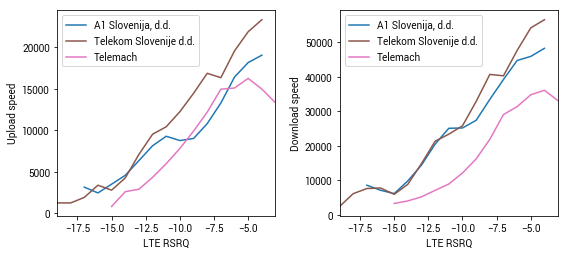

In [58]:
signal = query("SELECT lte_rsrp,lte_rsrq,signal_strength,speed_upload,speed_download,name FROM test,provider WHERE mobile_provider_id=provider.uid and plattform='Android'")
#VTR-L29', 'GT-I9305', 'WAS-LX1', 'MHA-L29', 'HUAWEI VNS-L21','GT-I8730', 'VKY-L29 imajo pozitivne vrednosti
signal['lte_rsrq'] = signal['lte_rsrq'].apply(lambda x: np.nan if x >-3 and x < 3 else x)
signal['lte_rsrq'] = signal['lte_rsrq'].apply(lambda x: np.nan if x <-19.5 else x)
signal['lte_rsrq'] = signal['lte_rsrq'].apply(lambda x: -1*x if x >2 else x)


rows = [('lte_rsrq', 'LTE RSRQ')]#, ('lte_rsrp','LTE RSRP')]
cols = [('speed_upload', 'Upload speed'), ('speed_download', 'Download speed')]

fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=False, sharey=False)

for ax,((row,row_label),(col,col_label)) in zip(axes.flat , [(row,col) for row in rows for col in cols]):
    signal.groupby(['name',row]).filter(lambda x: x[row].count()>=15).groupby(['name',row]).mean().reset_index().pivot(row, 'name', col).reset_index().rename_axis('').rename_axis('', axis=1).drop(
        ['T-2 d.o.o.'], axis=1, inplace=False).plot(ax=ax, x=row, figsize=(8,3.66), color=mobile_color[:1] + mobile_color[1+1:])
    ax.set(xlabel=row_label, ylabel=col_label)

plt.tight_layout()
plt.savefig('RSRQ.svg')
#call(["inkscape", "--file", "signali.svg", "--export-emf", "signali.emf" ]) 
plt.show()

## TCP port 25

0

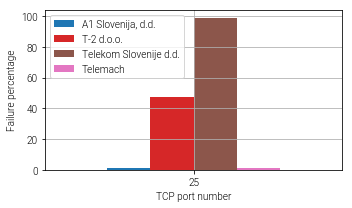

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
temp = query_tests(mobile=True, test='tcp')
#temp[temp.index.=='25'].plot(kind='bar', stacked=False,width=0.7,grid=True, title='', color=mobile_color,figsize=(5,3), rot=0, ax=axes)
temp[temp.index.str.startswith('T_ID:90')].plot(kind='bar', stacked=False,width=0.7,grid=True, title='', color=mobile_color,figsize=(5,3), rot=0, ax=axes)

axes.set_ylabel('Failure percentage')
axes.set_xlabel('TCP port number')

labels = [item.get_text() for item in axes.get_xticklabels()]
labels[0] = '25'
axes.set_xticklabels(labels)

plt.tight_layout()
#plt.savefig('TCP25.svg')
#call(["inkscape", "--file", "TCP25.svg", "--export-emf", "TCP25.emf" ]) 

## TCP ports

0

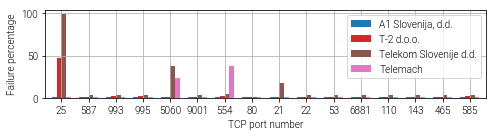

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
query_tests(mobile=True, test='tcp').plot(kind='bar', stacked=False,width=0.7,grid=True, title='', color=mobile_color,figsize=(7,2), rot=0, ax=axes)
axes.set_ylabel('Failure percentage')
axes.set_xlabel('TCP port number')

labels = [item.get_text() for item in axes.get_xticklabels()]
labels= [s.split(None, 1)[1] for s in labels]
axes.set_xticklabels(labels)

plt.tight_layout()
#plt.savefig('TCP.svg')
#call(["inkscape", "--file", "TCP.svg", "--export-emf", "TCP.emf" ]) 

## UDP ports 

0

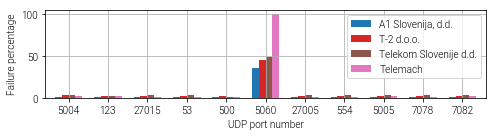

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False)
query_tests(mobile=True, test='udp').plot(kind='bar', stacked=False,width=0.7,grid=True, title='', color=mobile_color,figsize=(7,2), rot=0, ax=axes)
axes.set_ylabel('Failure percentage')
axes.set_xlabel('UDP port number')

labels = [item.get_text() for item in axes.get_xticklabels()]
labels= [s.split(None, 1)[1] for s in labels]
axes.set_xticklabels(labels)


plt.tight_layout()
#plt.savefig('UDP.svg')
#call(["inkscape", "--file", "UDP.svg", "--export-emf", "UDP.emf" ]) 

In [34]:
qos_test_objective

,uid,test,test_class,test_server,concurrency_group,test_desc,test_summary,param,results
0,76,voip,1,6,10,voip.testinfo,test.desc.voip,"{'in_port': '5060', 'timeout': '6000000000', '...",[{'evaluate': '%EVAL if (nn.coalesce(voip_resu...
1,131,dns,0,6,640,dns.testinfo,test.desc.dns,"{'host': 'gmx.net', 'record': 'A', 'timeout': ...","[{'operator': 'ge', 'on_failure': 'dns.failure..."
2,75,traceroute,1,6,0,trace.testinfo,test.desc.trace,"{'host': 'akostest.net', 'timeout': '350000000...","[{'operator': 'eq', 'on_failure': 'traceroute...."
3,163,http_proxy,1,6,400,http.testinfo,test.desc.http,{'url': 'https://www.akostest.net/qostest/refe...,"[{'operator': 'eq', 'on_failure': 'http.failur..."
4,39,tcp,0,6,200,tcp.out.testinfo,test.desc.tcp.out,"{'timeout': '3000000000', 'out_port': '53'}","[{'operator': 'eq', 'on_failure': 'tcp.failure..."
5,40,tcp,0,6,100,tcp.out.testinfo,test.desc.tcp.out,"{'timeout': '3000000000', 'out_port': '110'}","[{'operator': 'eq', 'on_failure': 'tcp.failure..."
6,41,tcp,0,6,300,tcp.out.testinfo,test.desc.tcp.out,"{'timeout': '3000000000', 'out_port': '143'}","[{'operator': 'eq', 'on_failure': 'tcp.failure..."
7,16,website,0,6,500,website.testinfo,test.desc.website,"{'url': 'https://nettest.specure.com/kepler', ...","[{'operator': 'eq', 'on_failure': 'website.err..."
8,105,dns,1,6,600,dns.testinfo,test.desc.dns,"{'host': '24ur.com', 'record': 'A', 'timeout':...","[{'operator': 'ge', 'on_failure': 'dns.failure..."
9,110,dns,1,6,610,dns.unknowndomain.info,test.desc.dns,"{'host': 'touch.darkspace.akostest.net', 'reco...","[{'operator': 'eq', 'on_failure': 'dns.unknown..."


In [35]:
%store qos_test_objective

Stored 'qos_test_objective' (DataFrame)
